Project to build and train a DCGAN

In [1]:
import tensorflow as tf
from tensorflow import keras
print('tensorflow version: {}'.format(tf.__version__))
print('keras version: {}'.format(keras.__version__))
print('GPU: {}'.format(tf.config.list_physical_devices('GPU')))

tensorflow version: 2.1.0
keras version: 2.2.4-tf
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import time
import matplotlib.pyplot as plt
import numpy as np

While in this project, we ultimately wish to train the GAN on the [lfw](https://www.tensorflow.org/datasets/catalog/lfw) dataset to make it generate human faces, we will start small and train it on the Fashion-MNIST for practice. Once that works, we will try to build upon our acquired knowledge to train on the lfw dataset. 

## load the Fashion-MNIST dataset

In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train, _), (_,_) = fashion_mnist.load_data()

In [4]:
print('shape of X_train: {}'.format(X_train.shape))
print('max pixel value: {}'.format(X_train.max()))
print('min pixel value: {}'.format(X_train.min()))

shape of X_train: (60000, 28, 28)
max pixel value: 255
min pixel value: 0


In [5]:
# scale the pixel value to have max = 1 and min = -1
max_px = X_train.max()
min_px = X_train.min()
A = 2/(max_px - min_px)
B = -1*(max_px + min_px)/(max_px - min_px)
X_train = A*X_train + B
print('new pixel max: {}'.format(X_train.max()))
print('new pixel min: {}'.format(X_train.min()))

new pixel max: 1.0
new pixel min: -1.0


## Build a DCGAN

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Reshape, Flatten
from tensorflow.keras.layers import Conv2D, Conv2DTranspose

### Generator:

In [7]:
# function to build a generator of given specifications
# Assumption: the first layer is a dense layer and 
# the rest are transpose Convolutional layers
# list layers consists of a list of tuples except for 
# the first entry which is a tuple: (num_units, activation) for the dense layer
# the second entry is tuple of two objects: the height and the width of 
# the feature maps obtained from reshaping the output of the first layer
# the rest of the enteries are tuples: (num_units, kernel_size, stride, padding, activation) for
# the transpose convolutional layers
# if batch_normalization == True, a BatchNormalization layer will be included after 
# every hidden layer except the first dense layer
# if batch_normalization == False and drop_prob!=0, then 
# a dropout layer is added after every layer except the dense layer
def build_generator(list_layers, coding_size = 100, batch_normalization = True, 
                    drop_prob = 0, kernel_initializer = 'glorot_uniform'):
    
    dense_units, dense_act = list_layers.pop(0)
    reshape_x, reshape_y = list_layers.pop(0)
    reshape_channels = int(dense_units/(reshape_x*reshape_y))
    
    generator = Sequential()
    generator.add(Dense(units=dense_units, activation = dense_act, 
                        input_shape=[coding_size], kernel_initializer = kernel_initializer))
    generator.add(Reshape([reshape_x, reshape_y, reshape_channels]))
    
    for layer in list_layers:
        if batch_normalization:
            generator.add(BatchNormalization())
        elif drop_prob!=0:
            generator.add(Dropout(drop_prob))
            
        num_units, kernel_size, stride, padding, activation = layer
        trans_conv = Conv2DTranspose(filters = num_units, kernel_size = kernel_size, 
                                     strides = stride, padding = padding, 
                                     activation = activation, 
                                     kernel_initializer = kernel_initializer)
        generator.add(trans_conv)
        
    
    return generator

In [8]:
l1 = (7*7*128, 'selu')
l2 = (7, 7)
l3 = (64, 5, 2, 'same', 'selu')
l4 = (1, 5, 2, 'same', 'tanh')

list_layers = [l1,l2,l3,l4]
generator = build_generator(list_layers)
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 1)         1601      
Total params: 840,705
Trainable params: 840,321
Non-trainable params: 384
________________________________________________

### Discriminator

In [9]:
# function to build a generator with given specifications
# list_layers consists of a list of tuples used to describe each convolutional layer
# tuples: (num_units, kernel_size, stride, padding, activation)
# if batch_normalization is True, then each layer is followed by a BatchNormalization layer
# if batch_normalization is False and drop_prob!=0, then each layer is followed by a dropout layer
def build_discriminator(list_layers, input_shape, batch_normalization = False, 
                        drop_prob = 0.3, kernel_initializer = 'glorot_uniform'):
    
    discriminator = Sequential()
    filters, kernel_size, stride, padding, activation = list_layers.pop(0) 
    conv2d = Conv2D(filters = filters, kernel_size = kernel_size, 
                    strides = stride, padding = padding, 
                    activation = activation, input_shape = input_shape, 
                    kernel_initializer = kernel_initializer)
    discriminator.add(conv2d)
    
    for filters, kernel_size, stride, padding, activation  in list_layers:
        if batch_normalization:
            discriminator.add(BatchNormalization())
        elif drop_prob!=0:
            discriminator.add(Dropout(drop_prob))
        
        conv2d = Conv2D(filters = filters, kernel_size = kernel_size, 
                    strides = stride, padding = padding, activation = activation,
                    kernel_initializer = kernel_initializer)
        
        discriminator.add(conv2d)
        
    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation = 'sigmoid'))
        
    return discriminator

In [10]:
l1 = (64, 5, 2, 'same', keras.layers.LeakyReLU(0.2))
l2 = (128, 5, 2, 'same', keras.layers.LeakyReLU(0.2))
list_layers = [l1,l2]
input_shape = [28,28,1]
discriminator = build_discriminator(list_layers, input_shape)
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6273      
Total params: 212,865
Trainable params: 212,865
Non-trainable params: 0
_________________________________________________________________


### combine the generator and the discriminator into a GAN

In [11]:
Gan = Sequential([generator, discriminator])

In [12]:
# compiling the discriminator
loss = 'binary_crossentropy'
optimizer = 'rmsprop'
metrics = ['acc']
discriminator.compile(loss = loss, optimizer = optimizer, metrics = metrics )
discriminator.trainable = False
Gan.compile(loss = loss, optimizer = optimizer, metrics = metrics)

## Custom training loop for the GAN

In [13]:
# function to train the gan
def train_gan(gan, training_images, num_epochs = 2, batch_size = 32, 
              coding_size = 100, num_plots = 10):
    
    plot_after = int(num_epochs/num_plots) # num epochs after which 
                                           # to plot an image to 
                                           # track the evolution of the GAN 
            
    # sample codings to track the evolution of the GAN        
    sample_codings = tf.random.normal(shape = (10, coding_size))        
            
    generator, discriminator = gan.layers
    
    idxs = tf.range(2*batch_size)
    for epoch in tf.range(num_epochs):
        
        start = time.time()
        for true_imgs in training_images:
            
            # generate a set of random codings
            codings = tf.random.normal(shape = (batch_size, coding_size))
            # convert the codings into images
            gan_imgs = generator(codings)
            y_gan = tf.constant([[0.]]*batch_size)
            
            # mix the gan images with the true images
            y_true = tf.constant([[1.]]*batch_size)
            all_imgs = tf.concat([true_imgs, gan_imgs], axis = 0)
            all_y = tf.concat([y_true, y_gan], axis = 0)
            
            # shuffle the set of mixed images
            shuffled_idxs = tf.random.shuffle(idxs)
            shuffled_imgs = tf.gather(all_imgs, shuffled_idxs)
            shuffled_y = tf.gather(all_y, shuffled_idxs)
            
            # phase 1: train the discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(shuffled_imgs, shuffled_y)
        
            # phase 2: train the generator on a new set of codings
            new_codings = tf.random.normal(shape = (batch_size, coding_size))
            discriminator.trainable = False
            gan.train_on_batch(codings, 1-y_gan)
        
        end = time.time()
        time_taken = end - start
        print('\repoch:{0:}/{1:}, time:{2: .2f}s '.format(epoch+1, num_epochs, time_taken), 
              end = '', flush = True)
        print('=', end = '')
        
        # plot the images produced by the GAN at different stages of training
        if epoch%plot_after == 0:
            sample_imgs = generator(sample_codings)
            # reshape the image if grayscale
            _ ,height, width, channels = sample_imgs.shape
            if channels == 1:
                sample_imgs = tf.reshape(sample_imgs,[-1, height, width])
            fig, ax = plt.subplots(figsize = (15, 5), ncols = 10 )
            for col in range(10):
                ax[col].imshow(sample_imgs[col])
                ax[col].axis('off')
            plt.show()    
        

## Create a batched dataset from X_train

In [14]:
# cast the type of X_train to float32
X_train = tf.cast(X_train, tf.float32)
# Add a channel dimension to X_train
X_train = tf.reshape(X_train, [-1,28,28,1])
# create a dataset
buffer_size = 10000
batch_size = 32
training_images = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size = buffer_size)
training_images = training_images.batch(batch_size).prefetch(3)

## Train the GAN

epoch:1/50, time: 28.45s =

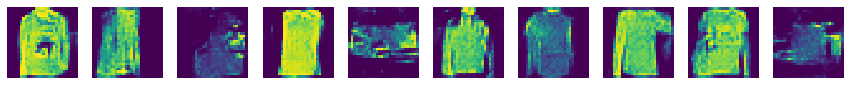

epoch:6/50, time: 25.62s =====

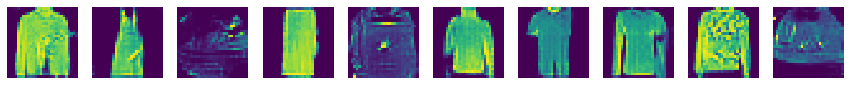

epoch:11/50, time: 24.98s ====

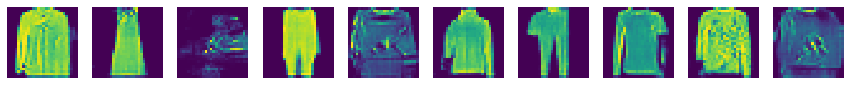

epoch:16/50, time: 26.46s =====

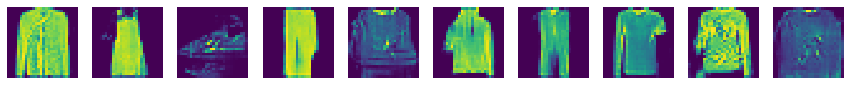

epoch:21/50, time: 25.04s =====

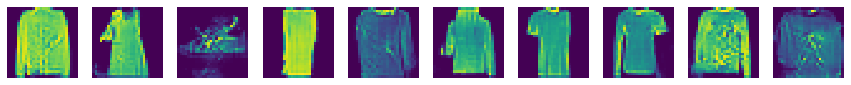

epoch:26/50, time: 25.32s =====

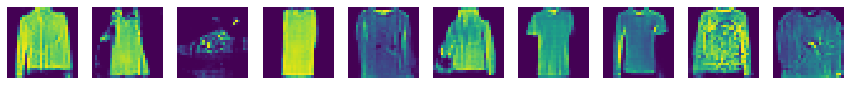

epoch:31/50, time: 25.63s =====

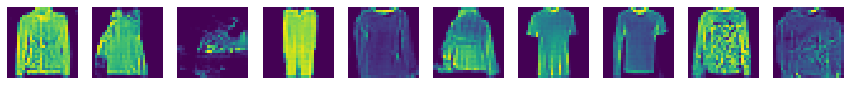

epoch:36/50, time: 25.53s =====

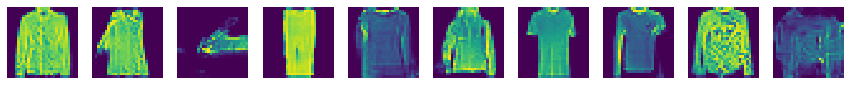

epoch:41/50, time: 24.80s =====

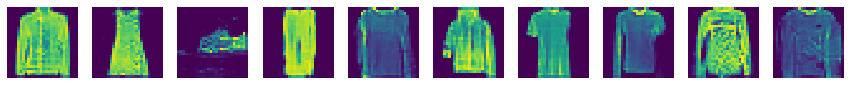

epoch:46/50, time: 24.70s =====

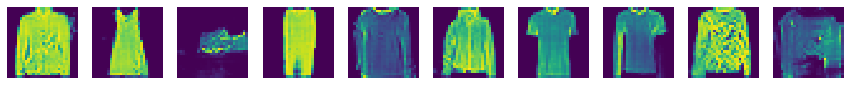

epoch:50/50, time: 24.98s ====

In [15]:
num_epochs = 50
coding_size = 100
train_gan(Gan, training_images, num_epochs, batch_size, coding_size)

## Fashion-MNIST Images produced by the GAN

In [16]:
num_imgs = 32
codings = tf.random.normal(shape = [num_imgs, coding_size])
generator, _ = Gan.layers
new_imgs = generator(codings).numpy().reshape((-1,28,28))
print('shape of new_images: {}'.format(new_imgs.shape))

shape of new_images: (32, 28, 28)


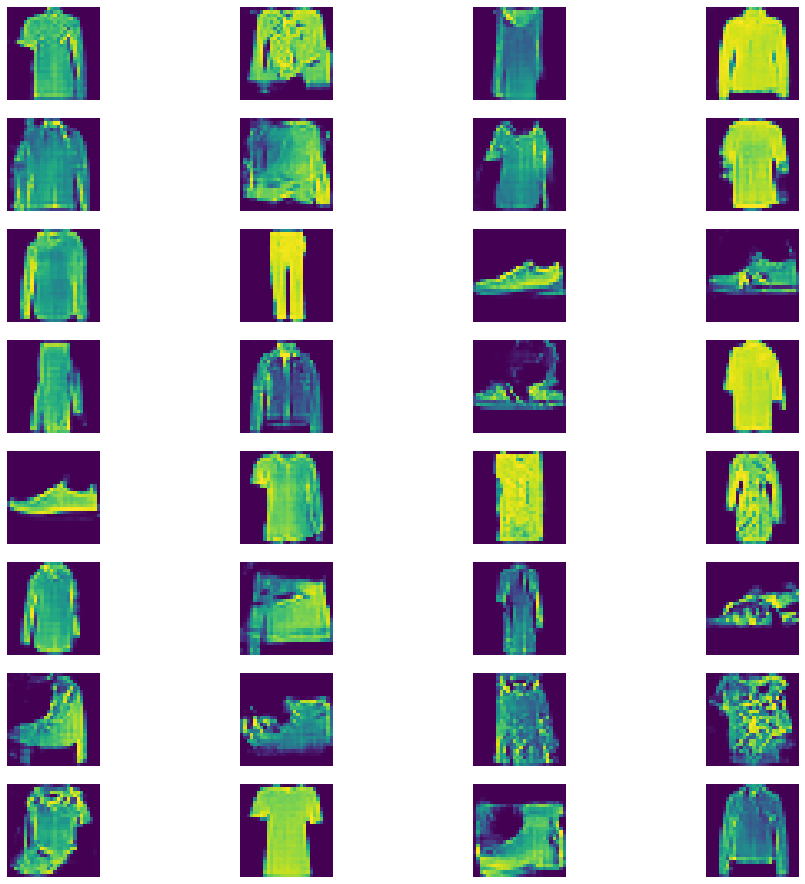

In [17]:
fig, ax = plt.subplots(figsize = (16, 16), nrows = 8, ncols = 4)
ctr = 0
for row in range(8):
    for col in range(4):
        ax[row, col].imshow(new_imgs[ctr])
        ax[row, col].axis('off')
        ctr+=1

In [18]:
# save the above output to dcgan_images directory
import os

path = os.path.join(os.getcwd(), 'dcgan_images', 'fashion_mnist.png')
print('path for fashion_mnist images: {}'.format(path))
fig.savefig(path)

path for fashion_mnist images: /home/prarit/MachineLearningProjects/DCGAN/dcgan_images/fashion_mnist.png


## LFW dataset

Having successfully trained a DCGAN on fashion-mnist dataset, let's see how it performs on the lfw dataset.

### load the LFW dataset

In [19]:
import tensorflow_datasets as tfds
# disable progress bar because otherwise, somehow,
# tfds gives me an error: FloatProgress not found. Please update jupyter and ipywidgets, 
tfds.disable_progress_bar()

In [20]:
# download using tfds.load()
# https://www.tensorflow.org/datasets/overview#tfdsload_a_dataset_in_one_line
lfw = tfds.load(name = 'lfw', split = 'train')

In [21]:
print('lfw_type: {}'.format(type(lfw)))

lfw_type: <class 'tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter'>


lfw as returned by tfds is a tensorflow dataset. Let's inspect an item of lfw

In [22]:
item = next(iter(lfw))
print('item_type: {}'.format(type(item)))

item_type: <class 'dict'>


We see that each item of lfw is a dictionary. It's natural to guess this consists of an image and it's label i.e. the name of the person in the image. Let's verify this. 

In [23]:
print('item_keys: {}'.format(item.keys()))

item_keys: dict_keys(['image', 'label'])


Indeed, the dictionary contains an image and its label. For our current purposes, labels are not very important and we only want the images. To do this we will have to define a preprocessing function that creates a new dataset from lfw that only consists of the images without their labels. 

In [24]:
print('shape of images in lfw: {}'.format(item['image'].shape))
print('max pix. value: {}'.format(item['image'].numpy().max()))
print('min pix. value: {}'.format(item['image'].numpy().min()))

shape of images in lfw: (250, 250, 3)
max pix. value: 255
min pix. value: 0


We will also normalize the pixel value to lie between 0 and 1

In [25]:
# function to ignore the labels and extract the images from lfw
def ignore_labels(img_dict):
    img = tf.cast(img_dict['image'], tf.float32) # must cast the pix. val to tf.float32 for multiplying an adding floats
    norm_img = tf.image.resize(img/255.0, (112,112) )
    return norm_img

In [26]:
batch_size = 32
buffer_size = 10000 
prefetch = 3
lfw_imgs = lfw.shuffle(buffer_size).batch(batch_size).map(lambda x: ignore_labels(x)).prefetch(3)

In [27]:
im=next(iter(lfw_imgs))
print('shape of im: {}'.format(im.shape))
print('max pix. val: {}'.format(tf.math.reduce_max(im)))
print('min pix. val: {}'.format(tf.math.reduce_min(im)))

shape of im: (32, 112, 112, 3)
max pix. val: 1.0
min pix. val: 0.0


### GAN generator

We can not use the previous GAN as is, since it was designed for grayscale images. We'll keep the generator to be almost the same except that we will change the output layer to have 3 feature maps of size 112 x 112

In [28]:
import tensorflow.keras.backend as K

In [60]:
K.clear_session()

In [61]:
coding_size = 100
l1 = (7*7*1024, 'selu')
l2 = (7, 7)
l3 = (512, 5, 2, 'same', 'selu')
l4 = (256, 5, 2, 'same', 'selu')
l5 = (128, 5, 2, 'same', 'selu')
l6 = (64, 5, 2, 'same', 'selu')
l7 = (3, 1, 1, 'same', 'sigmoid')
kernel_initializer = tf.keras.initializers.RandomNormal(stddev = 0.02)
list_layers = [l1,l2,l3,l4,l5,l6,l7]
generator = build_generator(list_layers, coding_size = coding_size, 
                            kernel_initializer = kernel_initializer)
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50176)             5067776   
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 1024)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 1024)        4096      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 512)       13107712  
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 512)       2048      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 256)       3277056   
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 256)       1

### Gan dicriminator

In [62]:
l1 = (64, 5, 2, 'same', keras.layers.LeakyReLU(0.2))
l2 = (128, 5, 2, 'same', keras.layers.LeakyReLU(0.2))
l3 = (256, 5, 2, 'same', keras.layers.LeakyReLU(0.2))
l4 = (512, 5, 2, 'same', keras.layers.LeakyReLU(0.2))
l5 = (512, 5, 2, 'same', keras.layers.LeakyReLU(0.2))
l6 = (1024, 5, 2, 'same', keras.layers.LeakyReLU(0.2))
kernel_initializer = tf.keras.initializers.RandomNormal(stddev = 0.02)
list_layers = [l1,l2,l3,l4,l5,l6]
input_shape = [112,112,3]
discriminator = build_discriminator(list_layers, input_shape, 
                            kernel_initializer = kernel_initializer)
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 56, 64)        4864      
_________________________________________________________________
dropout (Dropout)            (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       204928    
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 256)       819456    
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 512)        

### DCGAN

In [63]:
gan = Sequential([generator, discriminator])
gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 112, 112, 3)       22484867  
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 23972993  
Total params: 46,457,860
Trainable params: 46,453,892
Non-trainable params: 3,968
_________________________________________________________________


In [64]:
loss = 'binary_crossentropy'
optimizer = keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)
metrics = ['acc']
discriminator.compile(loss = loss, optimizer = optimizer, metrics = metrics)
discriminator.Trainable = False
gan.compile(loss = loss, optimizer = optimizer, metrics = metrics)

### train the GAN

epoch:1/300, time: 89.24s =

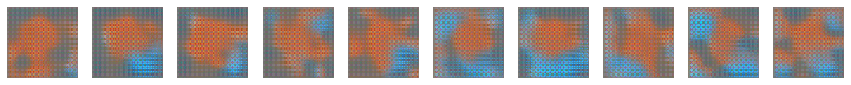

epoch:31/300, time: 89.58s =============================

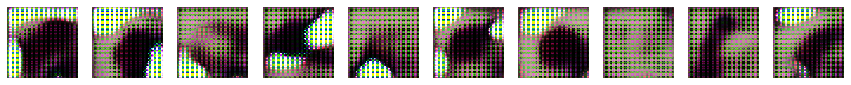

epoch:61/300, time: 89.31s ==============================

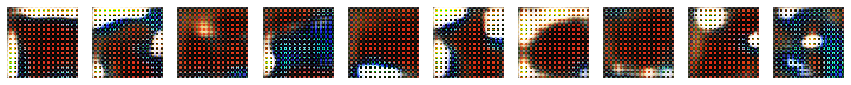

epoch:91/300, time: 89.38s ==============================

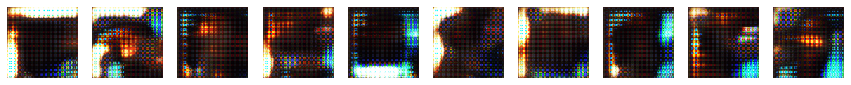

epoch:121/300, time: 89.79s =============================

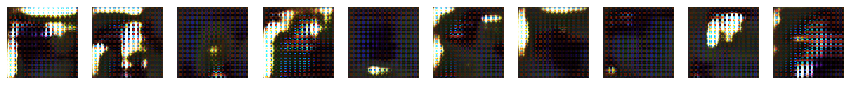

epoch:151/300, time: 89.37s ==============================

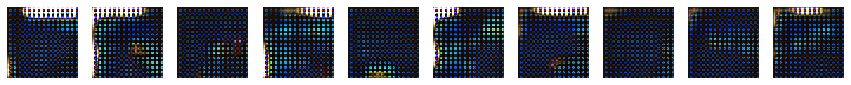

epoch:181/300, time: 89.90s ==============================

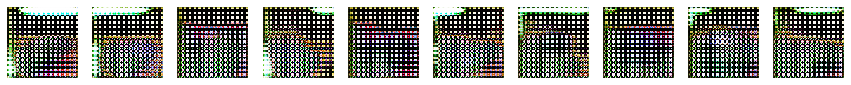

epoch:211/300, time: 89.61s ==============================

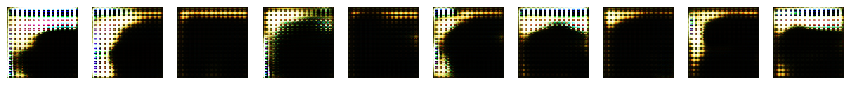

epoch:241/300, time: 89.70s ==============================

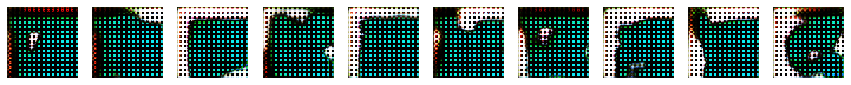

epoch:271/300, time: 89.74s ==============================

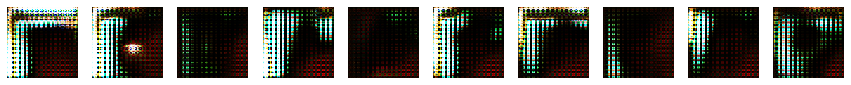

epoch:300/300, time: 89.47s =============================

In [65]:
num_epochs = 300
train_gan(gan, training_images = lfw_imgs, num_epochs = num_epochs, batch_size = batch_size,
          coding_size = coding_size )

### checkout the images produced by the gan

In [66]:
new_codings = tf.random.normal(shape = (batch_size, coding_size))
generator, _ = gan.layers
imgs = generator(new_codings)

In [67]:
print(imgs.shape)

(32, 112, 112, 3)


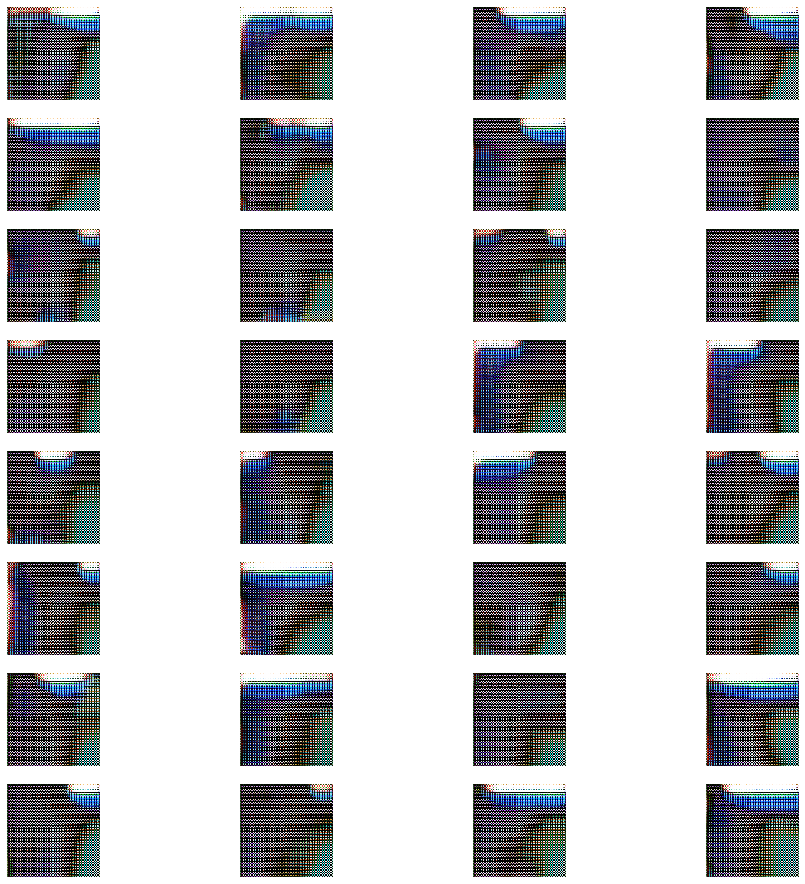

In [68]:
fig, ax = plt.subplots(figsize = (16,16), nrows = 8, ncols = 4)
ctr = 0
for row in range(8):
    for col in range(4):
        ax[row, col].imshow(imgs[ctr])
        ax[row, col].axis('off')
        ctr+=1

In [69]:
import os 

path = os.path.join(os.getcwd(), 'dcgan_images','lfw-faces.png')
print('path for lfw images: {}'.format(path))
fig.savefig(path)

path for lfw images: /home/prarit/MachineLearningProjects/DCGAN/dcgan_images/lfw-faces.png


In [70]:
generator, discriminator = gan.layers

In [71]:
discriminator.predict(imgs)

array([[0.8998484 ],
       [0.82616097],
       [0.8786755 ],
       [0.9064218 ],
       [0.9494183 ],
       [0.81644   ],
       [0.87696505],
       [0.83168733],
       [0.8113105 ],
       [0.85426325],
       [0.7587126 ],
       [0.8646172 ],
       [0.82338053],
       [0.82637835],
       [0.81739837],
       [0.84925455],
       [0.7934373 ],
       [0.7265983 ],
       [0.9067638 ],
       [0.8402057 ],
       [0.80964   ],
       [0.90610445],
       [0.7841317 ],
       [0.80313605],
       [0.8794447 ],
       [0.8661864 ],
       [0.84499305],
       [0.9383288 ],
       [0.854906  ],
       [0.6814416 ],
       [0.90434825],
       [0.9497154 ]], dtype=float32)

The images produced by the generator are no where closes to being human faces. However, when these images are fed to the discriminator, the discriminator assign them a reasonably high probability of being a real image.This indicates that the GAN is merely learn how to fool the discriminator :(

I tried various things:

1) Changing the generator architecture to be almost the same as that suggested in the [DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf)

2) training for different no. of epochs: 1,5,10,15,100, 300

3) relu vs selu activation in the generator

4) kernel sizes: 3, 5 in the lower layers of the generator and the discriminator

5) different batch sizes: 32, 128

6) changing the kernel initializer from default (i.e. glorot_uniform) to a zero centered random normal distribution with std.dev = 0.02 which same as that used in the above mentioned paper. 

Nothing seems to work. This might partly be because the training dataset is not big enough. Also notice that in the above mentioned paper it looks that they cropped out the training images such that a majority area of the images consisted of the face itself. On the otherhand, in the lfw dataset, the face forms a small fraction of the image of ~ 20 x 60 size out of the entire 112 x 112 image. 